In [1]:
# All installs here

# Download medium model

# Uncomment to install first time
#! pip install spacy
#! python -m spacy download en_core_web_md
# !pip install --upgrade pip
# !pip install numpy==1.18
# !pip install scipy==1.1.0
# !pip install scikit-learn==0.21.3
# !pip install networkx==2.4


In [2]:
# All imports and installs should be here
import os
import sys
import random


import pandas as pd
import numpy as np
from nltk import wordpunct_tokenize
import operator
import re, string
import math
import spacy
import copy

from nltk import Tree
# Space module import
import en_core_web_md
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from networkx import __version__ as nxv
import networkx.algorithms as networkx_algorithms

# linear_sum_assignment Hungarian algorithm
from scipy.optimize import linear_sum_assignment

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Nice progress bars
from tqdm.notebook import tqdm
# Used in plotting graphs 
import matplotlib.pyplot as plt

In [3]:
# All constants

COLAB_ENV = "colab"
LOCAL_ENV = "local"

SENTENCE_START_TOKEN = "sentence_start"
SENTENCE_END_TOKEN = "sentence_end"
UNKNOWN_TOKEN = "unknown_token"

In [4]:
def get_spacy_module():
  return en_core_web_md.load()

In [5]:
# To be able run this notebook from Google Colab and localy

def get_running_env():
  current_path = os.getcwd()
  if current_path == "/content":
    return COLAB_ENV
  return LOCAL_ENV

RUNNING_ENV = get_running_env()

In [6]:
# %%capture
# Supress output of the cell

def download_corpus():
    """
      Downloading corpus files for colab research.
    """ 
    if RUNNING_ENV == LOCAL_ENV:
      return
    files = [
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_train.txt',
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_test.txt',
    ]
    for f in files:
       !curl --remote-name \
          -H 'Accept: application/vnd.github.v3.raw' \
          --location https://api.github.com/repos/{f}

# download_corpus()

In [7]:
def get_data_location():
  return "" if RUNNING_ENV == COLAB_ENV else "./../dataset/msr-paraphrase-corpus/"

def add_start_end_sentence_tokens(s):
  return "%s %s %s" % (SENTENCE_START_TOKEN, s, SENTENCE_END_TOKEN)

def load_data(_preprocess_sentence=None, _train=False, _test=False):
    "Load the MSRP dataset."
    loc = get_data_location()
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    if _preprocess_sentence is None:
      _preprocess_sentence = lambda x: x

    sent1_train, sent2_train, sent1_test, sent2_test = [], [], [], []
    label_train, label_dev, label_test = [], [], []

    if _train:
        with open(trainloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_train.append(_preprocess_sentence(text[3]))
                sent2_train.append(_preprocess_sentence(text[4]))
                label_train.append(int(text[0]))

    if _test:
        with open(testloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_test.append(_preprocess_sentence(text[3]))
                sent2_test.append(_preprocess_sentence(text[4]))
                label_test.append(int(text[0]))

    if _train and _test:
        return [sent1_train, sent2_train], [sent1_test, sent2_test], [label_train, label_test]
    elif _train:
        return [sent1_train, sent2_train], label_train
    elif _test:
        return [sent1_test, sent2_test], label_test

In [8]:
data = load_data(_preprocess_sentence=None, _train=True, _test=False)

In [9]:
def get_sample_data(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return all_data[0][0][index], all_data[0][1][index], all_data[1][index]

def get_sample(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return {'s1': all_data[0][0][index], 's2': all_data[0][1][index], 'label': all_data[1][index]}

In [10]:
sample = get_sample_data()
sample

('Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.',
 'Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.',
 1)

In [11]:
nlp = get_spacy_module()

In [12]:
def get_dependancy_graph(s, display=False):
  doc = nlp(s)
  if display:
    spacy.displacy.render(doc, style="dep", jupyter=True)
  edges = []
  nodes = [{
      "node": "ROOT",
      "token": None,
      "is_fake": True, 
  }]
  for token in doc:
    nodes.append({
        "node": token.text,
        "token": token,
        "is_fake": False,
    })
    if token.dep_ == "ROOT":
      edges.append({
        "start": "ROOT",
        "end": token.text,
        "start_node_id": 0,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
    else:
      edges.append({
        "start": token.head.text,
        "end": token.text,
        "start_node_id":  token.head.i + 1,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
  return {"nodes": nodes, "edges": edges}

graph1 = get_dependancy_graph(sample[0], False)
graph2 = get_dependancy_graph(sample[1], False)
print(graph1)
print(graph2)

{'nodes': [{'node': 'ROOT', 'token': None, 'is_fake': True}, {'node': 'Amrozi', 'token': Amrozi, 'is_fake': False}, {'node': 'accused', 'token': accused, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'brother', 'token': brother, 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'whom', 'token': whom, 'is_fake': False}, {'node': 'he', 'token': he, 'is_fake': False}, {'node': 'called', 'token': called, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': 'the', 'token': the, 'is_fake': False}, {'node': 'witness', 'token': witness, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'of', 'token': of, 'is_fake': False}, {'node': 'deliberately', 'token': deliberately, 'is_fake': False}, {'node': 'distorting', 'token': distorting, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'evidence', 'token': evidence, 'is_fake': False

Here I try to explore diferent Graph similarity algorithms:

First approach
1.   Map nodes using Hungarian algorithm
2.   Count Graph Edit Distance GED also using Hungarian algorithm

Ideas to try:
* add treshold for node matching, only if > 0.5 for example merge nodes

Next ideas to try: 
* From graphs get graph based entities like path, or subgraphs.
* Combine vectors in these entities
* Count # of entities with some similarity threshold

Look at different structural graph features. Try to look at https://networkx.github.io/documentation/latest/reference/algorithms/index.html


One example could be Wiener index (need to think on normalization)



In [13]:
# Code is taken from https://github.com/Jacobe2169/ged4py

class EdgeGraph():
    def __init__(self, init_node, nodes):
        self.init_node=init_node
        self.nodes_ = nodes

    def nodes(self):
        return self.nodes_

    def size(self):
        return len(self.nodes)
    def __len__(self):
        return len(self.nodes_)

class AbstractGraphEditDistance(object):
    def __init__(self, g1, g2):
        self.g1 = g1
        self.g2 = g2

    def normalized_distance(self):
        """
        Returns the graph edit distance between graph g1 & g2
        The distance is normalized on the size of the two graphs.
        This is done to avoid favorisation towards smaller graphs
        """
        avg_graphlen = len(self.g1) + len(self.g2)
        return self.distance() / avg_graphlen

    def distance(self):
        return sum(self.edit_costs())

    def edit_costs(self):
        cost_matrix = self.create_cost_matrix()
        row_ind,col_ind = linear_sum_assignment(cost_matrix)
        return [cost_matrix[row_ind[i]][col_ind[i]] for i in range(len(row_ind))]

    def create_cost_matrix(self):
        """
        Creates a |N+M| X |N+M| cost matrix between all nodes in
        graphs g1 and g2
        Each cost represents the cost of substituting,
        deleting or inserting a node
        The cost matrix consists of four regions:
        substitute 	| insert costs
        -------------------------------
        delete 		| delete -> delete
        The delete -> delete region is filled with zeros
        """
        n = len(self.g1)
        m = len(self.g2)
        cost_matrix = np.zeros((n+m,n+m))
        #cost_matrix = [[0 for i in range(n + m)] for j in range(n + m)]
        nodes1 = self.g1.nodes() if float(nxv) < 2 else list(self.g1.nodes())
        nodes2 = self.g2.nodes() if float(nxv) < 2 else list(self.g2.nodes())

        for i in range(n):
            for j in range(m):
                cost_matrix[i,j] = self.substitute_cost(nodes1[i], nodes2[j])

        for i in range(m):
            for j in range(m):
                cost_matrix[i+n,j] = self.insert_cost(i, j, nodes2)

        for i in range(n):
            for j in range(n):
                cost_matrix[j,i+m] = self.delete_cost(i, j, nodes1)

        self.cost_matrix = cost_matrix
        return cost_matrix

    def insert_cost(self, i, j):
        raise NotImplementedError

    def delete_cost(self, i, j):
        raise NotImplementedError

    def substitute_cost(self, nodes1, nodes2):
        raise NotImplementedError

    def print_matrix(self):
        print("cost matrix:")
        for column in self.create_cost_matrix():
            for row in column:
                if row == sys.maxsize:
                    print ("inf\t")
                else:
                    print ("%.2f\t" % float(row))
            print("")

class EdgeEditDistance(AbstractGraphEditDistance):
    """
    Calculates the graph edit distance between two edges.
    A node in this context is interpreted as a graph,
    and edges are interpreted as nodes.
    """

    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        return sys.maxsize

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def substitute_cost(self, edge1, edge2):
        if edge1 == edge2:
            return 0.
        return 1

class GraphEditDistance(AbstractGraphEditDistance):
    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def substitute_cost(self, node1, node2):
        return self.relabel_cost(node1, node2) + self.edge_diff(node1, node2)

    def relabel_cost(self, node1, node2):
        if node1 == node2:
            return 0.
        else:
            return 1.

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        else:
            return sys.maxsize

    def pos_insdel_weight(self, node):
        return 1

    def edge_diff(self, node1, node2):
        edges1 = list(self.g1.edge[node1].keys()) if float(nxv) < 2 else list(self.g1.edges(node1))
        edges2 = list(self.g2.edge[node2].keys()) if float(nxv) < 2 else list(self.g2.edges(node2))
        if len(edges1) == 0 or len(edges2) == 0:
            return max(len(edges1), len(edges2))

        edit_edit_dist = EdgeEditDistance(EdgeGraph(node1,edges1), EdgeGraph(node2,edges2))
        return edit_edit_dist.normalized_distance()

def compare_graphs(g1, g2, print_details=False, use_normalized=True):
    ged = GraphEditDistance(g1, g2)

    if print_details:
        ged.print_matrix()

    return ged.normalized_distance() if use_normalized else ged.distance()


In [14]:
class HungarianGraphNodesMatcher:

  def __init__(self, _g1, _g2, threshold=0.5):
    self.g1 = _g1
    self.g2 = _g2
    self.node_threshold = threshold
    self.create_cost_matrix()
    self.match_nodes()
    

  def create_cost_matrix(self):
    self.matrix = np.zeros((len(self.g1["nodes"]), len(self.g2["nodes"])))
    for i1, n1 in enumerate(self.g1["nodes"]):
       for i2, n2 in enumerate(self.g2["nodes"]):
         if (not n1["is_fake"] and not n2["is_fake"] and 
            n1["token"].has_vector and n2["token"].has_vector):
           self.matrix[i1][i2] = n1["token"].similarity(n2["token"])
         elif n1["is_fake"] == n2["is_fake"]:
           self.matrix[i1][i2] = n1["node"] == n2["node"]
         else:
           self.matrix[i1][i2] = 0

    # Now we need to fleep scores, because Hungarian is trying to minimize
    self.cost = np.subtract(np.full(self.matrix.shape, 1), self.matrix)

  def get_pandas_matrix(self):
    df = pd.DataFrame(
        data=self.matrix,
        index=np.array([n["node"] for n in self.g1["nodes"]]),
        columns=np.array([n["node"] for n in self.g2["nodes"]])
      )
    
    return df

  def match_nodes(self):
    row_ind, col_ind = linear_sum_assignment(self.cost)

    self.graph1_to_graph2 = {
        item[0]: item[1] 
        for item in zip(row_ind, col_ind)
        if self.matrix[item[0]][item[1]] > self.node_threshold
    }
    self.row_ind = row_ind
    self.col_ind = col_ind

  def create_node_aliases(self):
    for id1, n1 in enumerate(self.g1["nodes"]):
      n1["alias"] = "G1_" + str(id1) + n1["node"]
    for id2, n2 in enumerate(self.g2["nodes"]):
      n2["alias"] = "G2_" + str(id2) + n2["node"] 
    for id1, id2 in self.graph1_to_graph2.items():
      n1 = self.g1["nodes"][id1]
      n2 = self.g2["nodes"][id2]
      n1["alias"] = "G1_" + str(id1) + "_" + n1["node"] + "_G2_" + str(id2) + "_" + n2["node"]
      n2["alias"] = n1["alias"]

  def build_graph(self, g):
    nx_g = nx.Graph()
    for edge in g["edges"]:
      start_node = g["nodes"][edge["start_node_id"]]
      end_node = g["nodes"][edge["end_node_id"]]
      nx_g.add_edge(start_node["alias"], end_node["alias"])
    return nx_g

  def get_converted_graphs(self):
    self.create_node_aliases()
    g1 = self.build_graph(self.g1)
    g2 = self.build_graph(self.g2)
    return g1, g2

  def print_matched_nodes(self):
    print ("Graph 1  =>   Graph 2")
    for id1, id2 in self.graph1_to_graph2.items():
      print(f"{self.g1['nodes'][id1]['node']}    =>   {self.g2['nodes'][id2]['node']}")

In [15]:
class GraphBuilder:

  def __init__(self):
    pass
  
  @classmethod
  def build_nx_graph_from_dt(cls, g):
    nx_g = nx.Graph()
    for index, node in enumerate(g["nodes"]):
      nx_g.add_node(index, node=node['node'], token=node['token'], is_fake=node['is_fake'])
    for edge in g["edges"]:
      nx_g.add_edge(edge["start_node_id"], edge["end_node_id"], dependancy_type=edge["type"])
    return nx_g


  @classmethod
  def build_nx_graph_from_sentance(cls, s):
    graph = get_dependancy_graph(s, False)
    return cls.build_nx_graph_from_dt(graph)

  @classmethod
  def get_root_node(cls, g):
    main_root_node = [n for n, _ in g.adj[0].items()][0]
    return g.nodes[main_root_node]


In [16]:
node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)

In [17]:
node_matcher.print_matched_nodes()
len(node_matcher.graph1_to_graph2)

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .


16

In [18]:
df = node_matcher.get_pandas_matrix()

df

,ROOT,Referring,to,him,as,only,"""",the,witness,"""",...,Amrozi,accused,his,brother,of,deliberately,distorting,his,evidence,.
ROOT,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amrozi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accused,0.0,0.462788,0.247302,0.428843,0.329721,0.288702,0.177370,0.245612,0.495963,0.177370,...,0.0,1.000000,0.409809,0.430317,0.245755,0.492152,0.162321,0.409809,0.455700,0.089694
his,0.0,0.448873,0.450099,0.818316,0.534291,0.459990,0.307721,0.589037,0.460539,0.307721,...,0.0,0.409809,1.000000,0.595102,0.470308,0.375484,0.248710,1.000000,0.372411,0.293258
brother,0.0,0.326865,0.278940,0.593552,0.359954,0.315489,0.165423,0.276650,0.382124,0.165423,...,0.0,0.430317,0.595102,1.000000,0.218296,0.202813,0.091600,0.595102,0.181388,0.244569
",",0.0,0.191477,0.260884,0.260457,0.453440,0.272194,0.225224,0.207785,0.204928,0.225224,...,0.0,0.154774,0.247196,0.260554,0.246289,0.178351,0.115272,0.247196,0.218267,0.421524
whom,0.0,0.530618,0.404365,0.627295,0.527354,0.508026,0.194234,0.375806,0.491248,0.194234,...,0.0,0.503349,0.543793,0.561806,0.362452,0.402099,0.123924,0.543793,0.391814,0.222853
he,0.0,0.501589,0.436620,0.827520,0.592211,0.577246,0.372794,0.491815,0.476299,0.372794,...,0.0,0.454249,0.791888,0.579133,0.374885,0.455827,0.210478,0.791888,0.417391,0.419956
called,0.0,0.503237,0.357370,0.417062,0.558222,0.401485,0.448924,0.532806,0.269240,0.448924,...,0.0,0.313714,0.409235,0.322105,0.401833,0.246508,0.108304,0.409235,0.295163,0.251584
"""",0.0,0.314289,0.299291,0.304552,0.358556,0.277636,1.000000,0.299336,0.192335,1.000000,...,0.0,0.177370,0.307721,0.165423,0.237327,0.202483,0.119719,0.307721,0.209467,0.292410


In [19]:
node_matcher.print_matched_nodes()
g1, g2 = node_matcher.get_converted_graphs()
score = compare_graphs(g1, g2)
print(f"Similarity score {score}")

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .
Similarity score 0.2086720867208672


In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

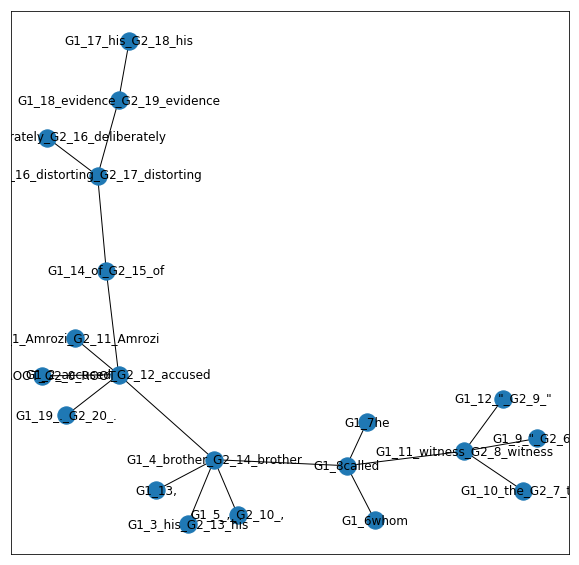

In [21]:
nx.draw_networkx(g1, with_labels=True)

In [22]:
def calculate_scores(limit=10):
  result = []
  for i in range(limit):
    s1 = data[0][0][i]
    s2 = data[0][1][i]
    label = data[1][i]
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.8)  
    g1, g2 = node_matcher.get_converted_graphs()
    score = compare_graphs(g1, g2)
    result.append((s1, s2, label, score))
  return result

result = calculate_scores()

In [23]:
for d in result:
  print (f"Label {d[2]}  |   Score {d[3]}")

Label 1  |   Score 0.1842818428184282
Label 0  |   Score 0.43574108818011253
Label 1  |   Score 0.274537037037037
Label 0  |   Score 0.3694677871148459
Label 1  |   Score 0.386436170212766
Label 1  |   Score 0.2107481060606061
Label 0  |   Score 0.537037037037037
Label 1  |   Score 0.21115689865689868
Label 0  |   Score 0.44702982202982205
Label 1  |   Score 0.21071428571428572


In [24]:
prepared_data = {}

In [25]:
class DataGenerator:
  @classmethod
  def get_train_data(cls):
    [sent1_train, sent2_train], label_train = load_data(_preprocess_sentence=None, _train=True, _test=False)
    return [
      {"s1": item[0], "s2": item[1], "label": item[2]}
      for item in zip(sent1_train, sent2_train, label_train)       
    ]

  @classmethod
  def get_test_data(cls):
    [sent1_test, sent2_test], label_test = load_data(_preprocess_sentence=None, _train=False, _test=True)
    
    return [
      {"s1": item[0], "s2": item[1], "label": item[2]}
      for item in zip(sent1_test, sent2_test, label_test)       
    ]

In [85]:
def prepare_data(feature_generator, force=False, limit=100000):
  feature_name = feature_generator.NAME
  global prepared_data
  if feature_name not in prepared_data or force:
    train_data = DataGenerator.get_train_data()
    test_data = DataGenerator.get_test_data()
    train_X = [
      feature_generator.get_features(item['s1'], item['s2'])
      for item in tqdm(train_data)
    ]
    train_Y = [item['label'] for item in train_data]

    test_X = [
      feature_generator.get_features(item['s1'], item['s2'])
      for item in tqdm(test_data)
    ]
    test_Y = [item['label'] for item in test_data]
    
    features = {}
    features['train_X'] = train_X
    features['train_Y'] = train_Y
    features['test_X'] = test_X
    features['test_Y'] = test_Y
    prepared_data[feature_name] = features

def verbose_data(feature_generator, limit=10, offset=0):
    train_data = DataGenerator.get_train_data()
    for item in train_data[offset:limit]:
      features = feature_generator.get_features(item['s1'], item['s2'])
      print(item['s1'])
      print(item['s2'])
      print(f"Label {item['label']}")
      print(features)
      print("*"* 8)

def get_metrics(feature_generator, classificator, force=False, limit=None, features_bitmap=None):
  prepare_data(feature_generator, force, limit)
  global prepared_data
  feature_name = feature_generator.NAME

  train_X = np.array(prepared_data[feature_name]['train_X'])
  test_X = np.array(prepared_data[feature_name]['test_X'])
  if features_bitmap is not None:
    train_X = train_X[:, features_bitmap]
    test_X = test_X[:, features_bitmap]

  classificator.fit(
    train_X,
    prepared_data[feature_name]['train_Y']
  )

  test_Y_predicted = classificator.predict(test_X)

  precision = precision_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  recall = recall_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  f1 = f1_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  accuracy = accuracy_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )

  return {
    "precision" : round(precision * 100, 2),
    "recall" : round(recall * 100, 2),
    "f1" : round(f1 * 100, 2),
    "accuracy" : round(accuracy * 100, 2),
  }

class BaselineFeatureGenerator:
  NAME = 'Baseline'

  def get_features(self, s1, s2):
    return np.array([1])

In [27]:
# classificator = LogisticRegression()
# baseline_feature_generator = BaselineFeatureGenerator()
# print("Baseline")
# get_metrics(baseline_feature_generator, classificator, True, 100)

In [28]:
class HungarianGraphFeatureGenerator:
  NAME = 'HungarianGraph'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    score_normalized = compare_graphs(g1, g2, False, True)
    score_raw = compare_graphs(g1, g2, False, False)
    return np.array([score_normalized, score_raw])

hungarian_feature_generator = HungarianGraphFeatureGenerator()

# It gives {'precision': 73.99, 'recall': 89.54, 'f1': 81.03, 'accuracy': 72.12}
# on LinearSVC()

In [29]:
class HungarianNodeFeatureGenerator:
  NAME = 'HungarianNode'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    n1, n2 = len(g1), len(g2)
    num_matched_nodes = len(node_matcher.graph1_to_graph2)
    percent_matched = num_matched_nodes * 2. / (n1 + n2)
    features = np.array([n1, n2, percent_matched])
    return features

hungarian_node_feature_generator = HungarianNodeFeatureGenerator()
# It gives {'precision': 74.5, 'recall': 90.67, 'f1': 81.79, 'accuracy': 73.16}
# on SGDClassifier(),

In [30]:
verbose_data(hungarian_node_feature_generator)


Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[20.        21.         0.7804878]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[18.         23.          0.58536585]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[22.  23.   0.8]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.
Label 0
[30.         21.          0.66666667]
********
The stoc

In [31]:
def base_classification_test(feature_generator, verbose=True, features_bitmap=None, force_feature_update=False):
  if force_feature_update:
    prepare_data(feature_generator, True, 10000)

  classificators = [
    {
      "name": "SVC",
      "classificator": SVC(),
    },
    {
      "name": "SVC(kernel = 'rbf', random_state = 0)",
      "classificator": SVC(kernel = 'rbf', random_state = 0),
    },
    {
      "name": "SVC(probability=True)",
      "classificator": SVC(probability=True),
    },
    {
      "name": "NuSVC",
      "classificator": NuSVC(),
    },
    {
      "name": "LinearSVC",
      "classificator": LinearSVC(),
    },
    {
      "name": "DecisionTreeClassifier",
      "classificator": DecisionTreeClassifier(),
    },
    {
      "name": "DecisionTreeClassifier(criterion='entropy',random_state=0)",
      "classificator": DecisionTreeClassifier(criterion="entropy",random_state=0),
    },
    {
      "name": "ExtraTreeClassifier",
      "classificator": ExtraTreeClassifier(),
    },
    {
      "name": "KNeighborsClassifier",
      "classificator": KNeighborsClassifier(),
    },
    {
      "name": " KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)",
      "classificator":  KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2),
    },
    {
      "name": "GaussianNB",
      "classificator": GaussianNB(),
    },
    {
      "name": "BernoulliNB",
      "classificator": BernoulliNB(),
    },
    {
      "name": "Perceptron",
      "classificator": Perceptron(),
    },
    {
      "name": "SGDClassifier",
      "classificator": SGDClassifier(),
    },
    {
      "name": "RandomForestClassifier",
      "classificator": RandomForestClassifier(),
    },
    {
      "name": "RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0)",
      "classificator": RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0),
    },
    {
      "name": "LogisticRegressionCV",
      "classificator": LogisticRegressionCV(),
    },
    {
      "name": "PassiveAggressiveClassifier",
      "classificator": PassiveAggressiveClassifier(),
    },
    {
      "name": "RidgeClassifierCV",
      "classificator": RidgeClassifierCV(),
    },
    {
      "name": "LogisticRegression(max_iter = 500000)",
      "classificator": LogisticRegression(max_iter = 500000),
    },
    {
      "name": "GradientBoostingClassifier",
      "classificator": GradientBoostingClassifier(),
    },
  ]
  res = []
  for item in tqdm(classificators):
    score = get_metrics(feature_generator, item["classificator"], features_bitmap=features_bitmap)
    res.append({"classificator": item["name"], "score": score})

  if verbose:
    for r in res:
      print(r["classificator"])
      print(r["score"])
  return res

In [32]:
# Uncomment to test
# prepare_data(hungarian_feature_generator, True, 100000)
# base_classification_test(hungarian_feature_generator)

In [33]:
# Uncomment to test
# prepare_data(hungarian_node_feature_generator, True, 100000)
# base_classification_test(hungarian_node_feature_generator)

In [106]:
class GraphTraversal:
  def __init__(self, graph=None, sentance=None):
    assert graph is not None or sentance is not None
    if graph is not None:
      self.g = graph
    else:
      self.g = GraphBuilder.build_nx_graph_from_sentance(sentance)
  
  def get_paths_from_root_to_leafs(self, root=0):
     #                 node. parent. path.      
    res, stack = [], [(root, None, [])]
    while stack:
        node, parent, path = stack.pop()
        path.append(node)
        neighbours = [n for n, _ in self.g.adj[node].items()]
        if len(neighbours) == 1 and neighbours[0] == parent:
            res.append(path)
        for n in neighbours:
          if n == parent:
            continue
          stack.append((n, node, path[:]))
    return res
    
  def get_all_paths_with_len(self, root=0, length=0):
    """
    Return list of pathes with specificified len + 1.
    The start is every node.
    
    For the tree:
           1
         2   3
       5
         6
         
    Len = 2:
    [1, 2, 5]
    [2, 5, 6]
    
    """
    
    #                  node. parent. path.                  
    res, stack = [], [(root, None, [])]
    started_new_path = {root}
    while stack:
        node, parent, path = stack.pop()
        path.append(node)
        neighbours = [n for n, _ in self.g.adj[node].items()]
        if len(path) == length + 1:
          res.append(path)
        for n in neighbours:
          if n == parent:
            continue
          if len(path) < length + 1:
            stack.append((n, node, path[:]))
          if n not in started_new_path:
            stack.append((n, node, []))
            started_new_path.add(n)
        
    return res

  def get_all_subtrees_with_depth(self, root=0, parent=None, length=0):
    """
      Return array of subtrees.
      Each subtree is defined by indexes of their nodes.
    """
    #                  node. parent. distance.  
    res, stack = [], [(root, parent, 0)]
    reached_depth = False
    while stack:
        node, _parent, distance = stack.pop()
        res.append(node)
        if distance >= length:
          reached_depth = True
          continue
        neighbours = [n for n, _ in self.g.adj[node].items()]
        for n in neighbours:
          if n == _parent:
            continue
          stack.append((n, node, distance + 1))
      
    all_subtrees = []
    if reached_depth:
      all_subtrees.append(res)
    for n, _ in self.g.adj[root].items():
      if n == parent:
        continue
      all_subtrees += self.get_all_subtrees_with_depth(n, root, length)

    return all_subtrees

In [115]:
def plot_graphs(graphs, word_labels=False):
  for g in graphs:
     fig, ax = plt.subplots(1, 1)
     if word_labels:
       nx.draw(g, arrowstyle="->", with_labels=True, pos=nx.kamada_kawai_layout(g), ax=ax, labels={n: g.nodes[n]['node'] for n in g.nodes})
     else:
       nx.draw(g, with_labels=True, pos=nx.kamada_kawai_layout(g), ax=ax)

In [123]:
# g1

traversal = GraphTraversal(graph=g1)
pathes = traversal.get_all_paths_with_len(length=2)

# dep_graph_1 = get_dependancy_graph(sample['s1'], False)
# for ed in dep_graph_1['edges']:
#     print(ed['start'] + " -> " + ed['end'])
# # print(dep_graph_1['edges'])
# plot_graphs([g1], True)
for path in pathes:
    for node in path:
        print(g1.nodes[node])
    print("*" * 8)

{'node': 'distorting', 'token': distorting, 'is_fake': False}
{'node': 'evidence', 'token': evidence, 'is_fake': False}
{'node': 'his', 'token': his, 'is_fake': False}
88888888
{'node': 'of', 'token': of, 'is_fake': False}
{'node': 'distorting', 'token': distorting, 'is_fake': False}
{'node': 'evidence', 'token': evidence, 'is_fake': False}
88888888
{'node': 'of', 'token': of, 'is_fake': False}
{'node': 'distorting', 'token': distorting, 'is_fake': False}
{'node': 'deliberately', 'token': deliberately, 'is_fake': False}
88888888
{'node': 'accused', 'token': accused, 'is_fake': False}
{'node': 'of', 'token': of, 'is_fake': False}
{'node': 'distorting', 'token': distorting, 'is_fake': False}
88888888
{'node': 'called', 'token': called, 'is_fake': False}
{'node': 'witness', 'token': witness, 'is_fake': False}
{'node': '"', 'token': ", 'is_fake': False}
88888888
{'node': 'called', 'token': called, 'is_fake': False}
{'node': 'witness', 'token': witness, 'is_fake': False}
{'node': 'the', 'to

In [36]:
class GraphFeatures:
  def __init__(self, graph=None, sentance=None):
    assert graph is not None or sentance is not None
    if graph is not None:
      self.g = graph
    else:
      self.g = GraphBuilder.build_nx_graph_from_sentance(sentance)
  
  def get_path_features(self, length=0):
    traversal = GraphTraversal(graph=self.g)
    pathes = traversal.get_all_paths_with_len(length=length)
    
    pathes_with_nodes = [
      [self.g.nodes[node] for node in path ]
      for path in pathes 
    ]

    filtered_pathes_with_nodes = [
      path 
      for path in pathes_with_nodes 
      if all(
          node["token"] is not None and node["token"].has_vector 
          for node in path
      )
    ]

    aggregated_vectors = [
       sum([node["token"].vector for node in path])
       for path in filtered_pathes_with_nodes
    ]

    return aggregated_vectors

  def get_subtree_features(self, length=0, remove_tree_without_vector=True, remove_stop_words=False, idf_model=None):
    """
    Return list of vectors, where each vector represent one subtree.
    Subtree is created by aggregating vectors in this subtree.

    Keyword arguments:
    length -- the real part (default 0.0)
    remove_tree_without_vector -- remove whole tree if at least one vector inside it 
      is empty (non common word)
    remove_stop_words - remove word from tree if it is stop word
    idf_model - If present, multiply vector by word idf
    """
    traversal = GraphTraversal(graph=self.g)
    subtrees = traversal.get_all_subtrees_with_depth(length=length)
    
    subtrees_with_nodes = [
      [self.g.nodes[node] for node in subtree ]
      for subtree in subtrees
    ]

    if remove_tree_without_vector:
      subtrees_with_nodes = [
        subtree 
        for subtree in subtrees_with_nodes 
        if all(
            node["token"] is not None and node["token"].has_vector 
            for node in subtree
        )
      ]

    idf = lambda word: 1
    
    if idf_model is not None:
        idf = lambda word: idf_model.get_idf(word)
    
    aggregated_vectors = [
       sum([
          node["token"].vector * idf(node["token"])
          for node in subtree 
          # If remove_tree_without_vector == false
          if node["token"] is not None and node["token"].has_vector
          and (not remove_stop_words or not node["token"].is_stop)
        ])
       for subtree in subtrees_with_nodes
    ]

    # Filter empty vectors
    aggregated_vectors = [
      v
      for v in aggregated_vectors
      if not np.isscalar(v)
    ]

    return aggregated_vectors

  def get_simple_edge_features(self):
    """
    Return list of edges
    """
    edges = []
    for (start_idx, end_idx, dependancy_type) in self.g.edges.data('dependancy_type'):
        item = {}
        item['start_idx'] = start_idx
        item['end_idx'] = end_idx
        item['dependancy_type'] = dependancy_type
        item['start_node'] = self.g.nodes[start_idx]
        item['end_node'] = self.g.nodes[end_idx]
        edges.append(item)
        
    return edges

In [37]:
class Vector:
  @classmethod
  def get_norm(cls, v):
    total = (v ** 2).sum()
    return np.sqrt(total) if total != 0 else 0

  @classmethod
  def similarity(cls, v1, v2):
    v1_norm = cls.get_norm(v1)
    v2_norm = cls.get_norm(v2)
    if v1_norm == 0 or v1_norm == 0:
      return 0.0
    return (np.dot(v1, v2) / (v1_norm * v2_norm))

class MatchFeatureVectors:
  @classmethod
  def match_feature_vectors(cls, features1, features2, similarity=0.8):
    """
      This function tries to do the following:
      1) For each vector in features1 try to find whether vector with good similarity exist in features2.
      Return ammount of matched vectors.
    """
    count = 0

    features1_norm = []
    for v1 in features1:
      for v2 in features2:
        score = Vector.similarity(v1, v2)
        if score > similarity:
          count += 1
          break
    return count

In [38]:
nxv

'2.4'

In [39]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])
g_f1 = GraphFeatures(g1)
g_f2 = GraphFeatures(g2)
f1 = g_f1.get_subtree_features(length=1)
f2 = g_f2.get_subtree_features(length=1)
score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=0.8)
print (score)

6


In [40]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])
g_f1 = GraphFeatures(g1)
g_f2 = GraphFeatures(g2)
f1 = g_f1.get_path_features(length=3)
f2 = g_f2.get_path_features(length=3)
score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=0.8)
print (score)

9


In [41]:
class PathFeatureGenerator:
  NAME = 'PathSimilarity'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_path_features(length=length)
    f2 = g_f2.get_path_features(length=length)
    
    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

path_feature_generator = PathFeatureGenerator()
# SGDClassifier {'precision': 74.34, 'recall': 90.41, 'f1': 81.59, 'accuracy': 72.87} [True, False, True, False, True]

In [42]:
verbose_data(path_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.86486486 0.74285714 1.03703704 1.         0.88888889]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.56410256 0.54054054 0.53846154 0.70588235 0.75      ]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.79069767 0.68292683 0.62068966 0.88888889 1.        ]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closin

It seems that PathFeatureGenerator with more length are giving more stable (core) feature.

In [43]:
# Uncomment to test
# prepare_data(path_feature_generator, True)
# base_classification_test(path_feature_generator)

In [44]:
def get_all_bitmasks(length):
  res = []
  for i in range(1, 2 ** length):
     bitmask = np.zeros(length)
     n = int(i)
     pos = 0
     while n > 0:
       bitmask[pos] = n % 2
       pos += 1
       n = n // 2
     bitmask = [b == 1 for b in bitmask]
     res.append(bitmask)
  return res


def feature_selection(feature_generator, top_results=5, verbose=False, bitmask_amount=None):
  global prepared_data
  feature_name = feature_generator.NAME
  assert feature_name in prepared_data
  length = len(prepared_data[feature_generator.NAME]["test_X"][0])
  bitmasks = get_all_bitmasks(length)
  results = []
  if bitmask_amount is not None:
    random.shuffle(bitmasks)
    bitmasks = random.sample(bitmasks, bitmask_amount)
  for bitmask in tqdm(bitmasks):
    if verbose:
      print(f"mask {bitmask}")
    scores = base_classification_test(feature_generator, features_bitmap=bitmask, verbose=False)
    for score in scores:
      if verbose:
        print(f"classificator {score['classificator']}")
        print(f"score {score['score']}")
        
      results.append({
        "mask": bitmask, 
        "score": score["score"], 
        "classificator": score["classificator"]
      })
  
  results = sorted(results, key=lambda k: k["score"]["accuracy"], reverse=True)
  print("Top Accuracy")
  for r in results[:top_results]:
    print(f"{r['classificator']} {r['score']} {r['mask']}")
  
  results = sorted(results, key=lambda k: k["score"]["f1"], reverse=True)
  print("Top F1")
  for r in results[:top_results]:
    print(f"{r['classificator']} {r['score']} {r['mask']}")

# Uncomment to run feature selection
# feature_selection(path_feature_generator)

In [45]:
doc = nlp("Give it back! He pleaded.")
token = doc[0]
vector = token.vector
total = (vector ** 2).sum()
norm = np.sqrt(total) if total != 0 else 0
print(norm)
print(token.vector_norm)

5.1312923
5.1312923


In [46]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])


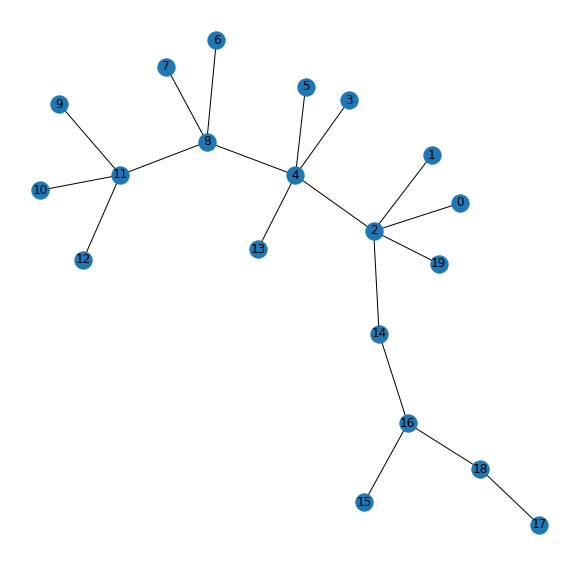

In [47]:
plot_graphs([g1])

In [48]:
g1.nodes[0]


{'is_fake': True, 'node': 'ROOT', 'token': None}

In [49]:
class SimpleGraphVector:
  @classmethod
  def get_graph_vector(cls, g):
    """
    g: networkx graph
    Return vector
    """
    vectors = []
    for node_index in g.nodes:
      node = g.nodes[node_index]
      if node['token'] is not None and node['token'].has_vector:
        attention = g.degree[node_index]
        vectors.append(attention * np.array(node['token'].vector))
    return sum(vectors)

In [50]:
class SimpleGraphVectorFeatureGenerator:
  """
  Compute only one feature - one vector of the whole tree
  """
  NAME = 'SimpleGraphVectorFeatureGenerator'

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    v1 = SimpleGraphVector.get_graph_vector(g1)
    v2 = SimpleGraphVector.get_graph_vector(g2)

    features = np.array([
      Vector.similarity(v1, v2)
    ])

    return features

simple_graph_vector_feature_generator = SimpleGraphVectorFeatureGenerator()
# GaussianNB {'precision': 71.35, 'recall': 92.5, 'f1': 80.56, 'accuracy': 70.32}

In [51]:
# Uncomment to test
# prepare_data(simple_graph_vector_feature_generator, True, 10000)
# base_classification_test(simple_graph_vector_feature_generator)

In [52]:
verbose_data(simple_graph_vector_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.9749242]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.92126673]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.9578174]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.
Label 0
[0.92144954]
********
The stock rose $2.11, or about 11 percent, to close Friday at $21.51 on the New York S

In [53]:
class SubtreeFeatureGenerator:
  NAME = 'SubtreeFeature'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_subtree_features(length=length)
    f2 = g_f2.get_subtree_features(length=length)
    
    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

subtree_feature_generator = SubtreeFeatureGenerator()
# LinearSVC {'precision': 74.85, 'recall': 89.8, 'f1': 81.65, 'accuracy': 73.16}
# SGDClassifier {'precision': 74.84, 'recall': 90.5, 'f1': 81.93, 'accuracy': 73.45}
# LogisticRegression(max_iter = 500000) {'precision': 75.02, 'recall': 90.32, 'f1': 81.96, 'accuracy': 73.57} [True, True, True, True, False]

In [54]:
# Uncomment to test
# prepare_data(subtree_feature_generator, True, 10000)
# scores = base_classification_test(subtree_feature_generator)
# Uncomment to run feature selection
# feature_selection(subtree_feature_generator)

In [55]:
verbose_data(subtree_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.86486486 0.85714286 1.         1.         0.        ]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.56410256 0.73684211 1.         1.2        1.33333333]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.79069767 0.76190476 1.         1.14285714 1.33333333]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closin

In [56]:
class RootNodeFeatureGenerator:
  NAME = 'RootNodeFeature'

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    root_node1 = GraphBuilder.get_root_node(g1)
    root_node2 = GraphBuilder.get_root_node(g2)

    if root_node1['token'].has_vector and root_node2['token'].has_vector:
      score = root_node1['token'].similarity(root_node2['token'])
    else:
      score = 0

    features = np.array([
      score,
    ])

    return features

root_node_feature_generator = RootNodeFeatureGenerator()
# SVC {'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
# By itself is not usefull, but maybe in combination could be used.

In [57]:
# prepare_data(root_node_feature_generator, True, 10000)
# scores = base_classification_test(root_node_feature_generator)

In [58]:
# class GraphAlgoFeatureGenerator:
#   NAME = 'GraphAlgoFeature'

#   def get_features(self, s1, s2):
#     g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
#     g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

#     s1 = networkx_algorithms.smetric.s_metric(g1, normalized=False)
#     s2 = networkx_algorithms.smetric.s_metric(g2, normalized=False)
    
#     w1 = networkx_algorithms.wiener.wiener_index(g1)
#     w2 = networkx_algorithms.wiener.wiener_index(g2)

#     # r1 = networkx_algorithms.richclub.rich_club_coefficient(g1)
#     # r2 = networkx_algorithms.richclub.rich_club_coefficient(g2)

#     features = np.array([
#       s1 / (s1 + s2),
#       s2 / (s1 + s2),
#       abs(s1 - s2) / (s1 + s2),
#       w1 / (w1 + w2),
#       w2 / (w1 + w2),
#       abs(w1 - w2) / (w1 + w2),
#       # abs(r1[0] - r2[0]),
#       # abs(r1[1] - r2[1]),
#       # abs(r1[2] - r2[2]),      
#     ])

#     return features

# graph_algo_feature_generator = GraphAlgoFeatureGenerator()
# Even after feature selection
# PassiveAggressiveClassifier {'precision': 68.34, 'recall': 95.2, 'f1': 79.56, 'accuracy': 67.48} [False, False, False, True, True, True]
# So it's not useful

In [59]:
# prepare_data(graph_algo_feature_generator, True, 10000)
# scores = base_classification_test(graph_algo_feature_generator)
# feature_selection(graph_algo_feature_generator, verbose=False)

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')
# import json
# from json import JSONEncoder

# class NumpyArrayEncoder(JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return JSONEncoder.default(self, obj)

# with open('/content/drive/My Drive/phd/prepared_data.json', 'w') as f:
#   json.dump(prepared_data, f, cls=NumpyArrayEncoder)

Try to remove stop words (don't use their vectors):
 - Results:
    SubtreeFeature - not very usefull

In [61]:
class SubtreeFeatureGeneratorWithoutStopWords:
  NAME = 'SubtreeFeatureWithoutStopWords'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_subtree_features(length=length, remove_stop_words=True)
    f2 = g_f2.get_subtree_features(length=length, remove_stop_words=True)
    
    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

subtree_without_stop_words_feature_generator = SubtreeFeatureGeneratorWithoutStopWords()

In [62]:
# prepare_data(subtree_without_stop_words_feature_generator, True, 10000)
# scores = base_classification_test(subtree_without_stop_words_feature_generator)
# feature_selection(subtree_without_stop_words_feature_generator, verbose=False)

# Results
# SVC {'precision': 72.9, 'recall': 91.46, 'f1': 81.13, 'accuracy': 71.71}
# feature selection didn't improve results


In [63]:
class AllFeatureGenerator:
  NAME = 'AllFeatures'

  def get_features(self, s1, s2):
    generators = [
        HungarianGraphFeatureGenerator(),
        HungarianNodeFeatureGenerator(),
        PathFeatureGenerator(),
        SubtreeFeatureGenerator(),
    ]
    features = np.array([])
    for generator in generators:
      features = np.append(features, generator.get_features(s1, s2))
    return features

all_feature_generator = AllFeatureGenerator()
# LogisticRegression(max_iter = 500000) {'precision': 76.04, 'recall': 88.84, 'f1': 81.95, 'accuracy': 73.97}
# RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0) {'precision': 76.32, 'recall': 88.23, 'f1': 81.84, 'accuracy': 73.97}

# RidgeClassifierCV {'precision': 76.28, 'recall': 89.71, 'f1': 82.45, 'accuracy': 74.61} [True, False, True, False, False, True, False, False, True, False, True, True, False, True, False]
# LogisticRegressionCV {'precision': 76.8, 'recall': 88.58, 'f1': 82.27, 'accuracy': 74.61} [True, False, True, True, True, False, False, True, True, True, False, False, True, True, False]
# RidgeClassifierCV {'precision': 76.09, 'recall': 90.15, 'f1': 82.52, 'accuracy': 74.61} [True, True, False, False, False, True, True, False, False, False, True, True, False, False, True]
# LogisticRegression(max_iter = 500000) {'precision': 76.4, 'recall': 89.45, 'f1': 82.41, 'accuracy': 74.61} [True, False, True, True, True, True, False, True, True, True, False, False, False, True, False]


In [64]:
# prepare_data(all_feature_generator, True, 10000)
# scores = base_classification_test(all_feature_generator)
# all_feature_generator = AllFeatureGenerator()
# feature_selection(all_feature_generator, verbose=True, bitmask_amount=100)

In [65]:
class AllFeatureGeneratorV1:
  NAME = 'AllFeatureV1'

  def get_features(self, s1, s2):
    generators = [
        HungarianGraphFeatureGenerator(),
        HungarianNodeFeatureGenerator(),
        PathFeatureGenerator(),
        SubtreeFeatureGenerator(),
        SubtreeFeatureGeneratorWithoutStopWords(),
    ]
    features = np.array([])
    for generator in generators:
      features = np.append(features, generator.get_features(s1, s2))
    return features

all_feature_generator_v1 = AllFeatureGeneratorV1()

In [66]:
# prepare_data(all_feature_generator, True, 10000)
# scores = base_classification_test(all_feature_generator)
# all_feature_generator = AllFeatureGenerator()
# feature_selection(all_feature_generator, verbose=False, bitmask_amount=100)

# Top Accuracy
# LinearSVC {'precision': 76.62, 'recall': 89.45, 'f1': 82.54, 'accuracy': 74.84} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# RidgeClassifierCV {'precision': 76.57, 'recall': 89.45, 'f1': 82.51, 'accuracy': 74.78} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# LogisticRegression(max_iter = 500000) {'precision': 76.79, 'recall': 88.84, 'f1': 82.38, 'accuracy': 74.72} [False, True, False, True, True, True, False, False, False, True, False, True, False, False, True]
# LogisticRegression(max_iter = 500000) {'precision': 76.59, 'recall': 89.28, 'f1': 82.45, 'accuracy': 74.72} [False, False, True, True, True, False, False, True, False, False, True, False, True, True, False]
# RidgeClassifierCV {'precision': 76.83, 'recall': 88.75, 'f1': 82.36, 'accuracy': 74.72} [False, False, False, False, True, True, False, True, False, False, False, True, True, True, False]
# Top F1
# LogisticRegression(max_iter = 500000) {'precision': 76.01, 'recall': 90.32, 'f1': 82.55, 'accuracy': 74.61} [True, False, True, False, False, True, True, True, False, True, False, False, False, True, True]
# LinearSVC {'precision': 76.62, 'recall': 89.45, 'f1': 82.54, 'accuracy': 74.84} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# RidgeClassifierCV {'precision': 76.57, 'recall': 89.45, 'f1': 82.51, 'accuracy': 74.78} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# SGDClassifier {'precision': 75.22, 'recall': 91.28, 'f1': 82.47, 'accuracy': 74.2} [False, True, True, False, True, False, False, False, False, False, True, True, False, True, False]
# Perceptron {'precision': 75.97, 'recall': 90.15, 'f1': 82.46, 'accuracy': 74.49} [True, False, True, False, True, False, False, False, False, False, True, True, True, False, False]

In [67]:
class AnalyzePredictions:
  CORRECT_PREDICTIONS = 'CORRECT_PREDICTIONS'
  WRONG_PREDICTIONS = 'WRONG_PREDICTIONS'
  
  @classmethod
  def get_predictions(cls, feature_generator, classificator, mode, verbose=True, limit=10):
    feature_name = feature_generator.NAME
    assert feature_name in prepared_data, "No features found"

    test_data = DataGenerator.get_test_data()
    
    train_X = prepared_data[feature_name]['train_X']
    test_X = prepared_data[feature_name]['test_X']
    train_Y = prepared_data[feature_name]['train_Y']
    test_Y = prepared_data[feature_name]['test_Y']


    classificator.fit(train_X, train_Y)

    test_Y_predicted = classificator.predict(test_X)

    res = []
    for data, features, prediction, label in zip(test_data, test_X, test_Y_predicted, test_Y):
      if (mode == AnalyzePredictions.CORRECT_PREDICTIONS and prediction == label or 
         mode == AnalyzePredictions.WRONG_PREDICTIONS and prediction != label):
          res.append({
              "raw": data,
              "features": features,
              "prediction": prediction,
              "label": label
          })
          if verbose:
            print(data)
            print(features)
            print(f"Prediction {prediction}, but label {label}")
          limit -= 1
          if limit == 0:
            break
    return res



In [68]:
def print_sample(p):
  print (p["raw"]["s1"])
  print (p["raw"]["s2"])
  print (f"Label {p['raw']['label']}")
  print (f"Prediction {p['prediction']}")
  print (p["features"])

# model = LinearSVC()
# prepare_data(subtree_feature_generator, True, 10000)
# not_predicted = AnalyzePredictions.get_predictions(subtree_feature_generator, model, AnalyzePredictions.WRONG_PREDICTIONS,  verbose=False)
# ok_predicted = AnalyzePredictions.get_predictions(subtree_feature_generator, model, AnalyzePredictions.CORRECT_PREDICTIONS,  verbose=False, limit=10)
# sample_wrong = not_predicted[0]
# sample_ok = ok_predicted[0]

# print_sample(sample_wrong)
# print_sample(sample_ok)



Starting to work with edges

In [69]:
class SimpleEdgeMatcher:
  NAME = 'SimpleEdgeMatcher'

  SIMILARITY = 0.8

  def simple_match_edges(self, g_f1, g_f2):
    f1 = g_f1.get_simple_edge_features()
    f2 = g_f2.get_simple_edge_features()
    
    score = 0
    for edge1 in f1:
        if (edge1['start_node']['token'] is None or 
            not edge1['start_node']['token'].has_vector
            or edge1['end_node']['token'] is None
            or not edge1['end_node']['token'].has_vector):
                continue
        for edge2 in f2:
            if (edge2['start_node']['token'] is None 
            or not edge2['start_node']['token'].has_vector
            or edge2['end_node']['token'] is None
            or not edge2['end_node']['token'].has_vector):
                continue
            if (Vector.similarity(
                    edge1['start_node']['token'].vector, 
                    edge2['start_node']['token'].vector
                ) > self.SIMILARITY
                and Vector.similarity(
                    edge1['end_node']['token'].vector, 
                    edge2['end_node']['token'].vector
                ) > self.SIMILARITY
               ):
                score += 1
        
    similarity_score = (1. * score) / (len(f1) * len(f2))
    
    return similarity_score

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.simple_match_edges(g_f1, g_f2)
    ])
    
    return features

simple_edge_matcher_feature_generator = SimpleEdgeMatcher()
# Don't efective 
# GaussianNB {'precision': 67.78, 'recall': 97.56, 'f1': 79.99, 'accuracy': 67.54}
# RidgeClassifierCV {'precision': 66.82, 'recall': 99.74, 'f1': 80.03, 'accuracy': 66.9}

In [70]:
# prepare_data(simple_edge_matcher_feature_generator, True, 10000)
# scores = base_classification_test(simple_edge_matcher_feature_generator)

In [71]:
class SimpleEdgeMatcherWithDependancy:
  NAME = 'SimpleEdgeMatcherWithDependancy'

  SIMILARITY = 0.8

  def simple_match_edges_with_dependancy_type(self, g_f1, g_f2):
    f1 = g_f1.get_simple_edge_features()
    f2 = g_f2.get_simple_edge_features()
    
    score = 0
    total = 0
    for edge1 in f1:
        if (edge1['start_node']['token'] is None or 
            not edge1['start_node']['token'].has_vector
            or edge1['end_node']['token'] is None
            or not edge1['end_node']['token'].has_vector):
                continue
        for edge2 in f2:
            if (edge2['start_node']['token'] is None 
            or not edge2['start_node']['token'].has_vector
            or edge2['end_node']['token'] is None
            or not edge2['end_node']['token'].has_vector):
                continue
            if (Vector.similarity(
                    edge1['start_node']['token'].vector, 
                    edge2['start_node']['token'].vector
                ) > self.SIMILARITY
                and Vector.similarity(
                    edge1['end_node']['token'].vector, 
                    edge2['end_node']['token'].vector
                ) > self.SIMILARITY
               ):
                if (edge1['dependancy_type'] == edge2['dependancy_type']):
                    score += 1
                total += 1
        
    similarity_score = 0 if total == 0 else (1. * score) / total
    
    return similarity_score

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.simple_match_edges_with_dependancy_type(g_f1, g_f2)
    ])
    
    simple_edge_matcher_feature_generator = SimpleEdgeMatcher()
    features = np.append(features, simple_edge_matcher_feature_generator.get_features(s1, s2))


    return features

simple_edge_matcher_with_dependancy_feature_generator = SimpleEdgeMatcherWithDependancy()
# GradientBoostingClassifier {'precision': 68.77, 'recall': 94.25, 'f1': 79.51, 'accuracy': 67.71}

In [72]:
# prepare_data(simple_edge_matcher_with_dependancy_feature_generator, True, 10000)
# scores = base_classification_test(simple_edge_matcher_with_dependancy_feature_generator)

In [73]:
class SimpleApproximateBigramKernel:
  """
        From https://www.aclweb.org/anthology/L16-1452.pdf
        Simple Approximate Bigram Kernel (SABK)
  """

  NAME = 'SimpleApproximateBigramKernel'
  EDGE_SIMILARITY_SCORE = 2

  @classmethod  
  def node_similarity(cls, node1, node2):
    if (node1['token'] is None or 
        node2['token'] is None or 
        not node1['token'].has_vector or 
        not node2['token'].has_vector
       ):
        return 1 if node1['node'] == node2['node'] else 0
    else:
        return Vector.similarity(
            node1['token'].vector, 
            node2['token'].vector
        )
  @classmethod  
  def edge_similarity(cls, edge1, edge2):
    return SimpleApproximateBigramKernel.EDGE_SIMILARITY_SCORE if edge1['dependancy_type'] == edge2['dependancy_type'] else 1

  @classmethod  
  def similarity(cls, edge1, edge2):
    start_node_similarity = cls.node_similarity(edge1['start_node'], edge2['start_node'])
    end_node_similarity = cls.node_similarity(edge1['end_node'], edge2['end_node'])
    
    edge_similarity = cls.edge_similarity(edge1, edge2)
    
    return (start_node_similarity + end_node_similarity) * edge_similarity
    
  @classmethod  
  def compute_simple_approximate_bigram_kernel(cls, g_f1, g_f2):
    f1 = g_f1.get_simple_edge_features()
    f2 = g_f2.get_simple_edge_features()
    
    similarity_score = 0

    for edge1 in f1:
        for edge2 in f2:
            similarity_score += cls.similarity(edge1, edge2)
        
    similarity_score = (similarity_score * 1.) / (len(g1.nodes) + len(g2.nodes))
    
    return similarity_score

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      SimpleApproximateBigramKernel.compute_simple_approximate_bigram_kernel(g_f1, g_f2)
    ])

    return features

simple_approximate_bigram_kernel = SimpleApproximateBigramKernel()
# LogisticRegression(max_iter = 500000) {'precision': 67.65, 'recall': 98.08, 'f1': 80.07, 'accuracy': 67.54}

In [74]:
# scores = base_classification_test(simple_approximate_bigram_kernel, force_feature_update=True)

In [75]:
class TfIdf:
    def __init__(self, data):
        self.data = data
        self.prepare_corpus()
        self.fit()
        
    def prepare_corpus(self):
        self.corpus = [x['s1'] for x in self.data] + [x['s2'] for x in self.data]
        self.corpus = list(set(self.corpus))
        self.corpus = sorted(self.corpus)
        self.corpus_len = len(self.corpus)
                
        self.sent_to_index = {}
        for index, s in enumerate(self.corpus):
            self.sent_to_index[s] = index
            
    def fit(self):
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(self.corpus)
        
        self.vectorizer = vectorizer
        
        self.words_list = vectorizer.get_feature_names()
        self.idf = vectorizer._tfidf.idf_
        
        self.word_to_index = {}
        for index, w in enumerate(self.words_list):
            self.word_to_index[w] = index
    
    def use_idf(self, t):
        return (t.is_alpha and 
                not (t.is_space or t.is_punct or 
                     t.is_stop or t.like_num))
    
    def get_idf(self, token):
        if not self.use_idf(token):
            return 1
        return self.get_word_idf(token.text)
    
    def get_word_idf(self, word):
        if word in self.word_to_index:
            idf = self.idf[self.word_to_index[word]]
        else:
            # https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/feature_extraction/text.py#L1443
            idf = np.log(self.corpus_len + 1 / 1) + 1
#         print("Calling idf for " + word + " = " + str(idf))
        return idf
        

In [76]:
idf_model = TfIdf(DataGenerator.get_test_data())

In [77]:
class SubtreeFeatureGeneratorIdf:
  NAME = 'SubtreeFeatureIdf'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_subtree_features(length=length, idf_model=idf_model)
    f2 = g_f2.get_subtree_features(length=length, idf_model=idf_model)
    
    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

subtree_feature_generator_idf = SubtreeFeatureGeneratorIdf()
# SGDClassifier {'precision': 71.5, 'recall': 95.38, 'f1': 81.73, 'accuracy': 71.65}
# Not better than simple subtree_feature_generator

In [78]:
# scores = base_classification_test(subtree_feature_generator_idf, force_feature_update=True)

In [79]:
class GeneralFeatures:
    
    @classmethod
    def get_s_len(cls, s):
        doc = nlp(s)
        return np.array([len(doc)])
    
    @classmethod
    def get_n_grams(cls, s, n, doc=None):
        if doc is None:
            d = nlp(s)
        else:
            d = doc
        
        res = []
        count=0
        for token in d[:len(d)-n+1]:  
           res.append(d[count:count+n])  
           count=count+1  
        return res
        

In [129]:
class NodeSimilarity:
    
    
    @classmethod
    def basic(cls, node1, node2):
        if (node1['token'] is None or 
            node2['token'] is None or 
            not node1['token'].has_vector or 
            not node2['token'].has_vector
           ):
            return 1 if node1['node'] == node2['node'] else 0
        else:
            return Vector.similarity(
                node1['token'].vector, 
                node2['token'].vector
            )

In [134]:
class MarchFeatureGenerator:
    NAME = 'MarchFeature'

    def get_feature_1(self, s1, s2):
        len_s1 = GeneralFeatures.get_s_len(s1)
        len_s2 = GeneralFeatures.get_s_len(s2)
        
        def f(len_s1, len_s2):
            d_1 = (len_s1 - len_s2) * 1. / len_s1
            d_2 = 1./ 0.8 ** (len_s1 - len_s2)
            r = np.array([d_1, d_2])
            return r
        
        feature_1 = np.array([])
        feature_1 = np.append(feature_1, f(len_s1, len_s2))
        feature_1 = np.append(feature_1, f(len_s2, len_s1))
        return feature_1
    
    def get_feature_2(self, s1, s2):
        doc_1 = nlp(s1)
        doc_2 = nlp(s2)
        
        def compare_n_grams(s1, s2, doc_1, doc_2,  n):
            s1_list = GeneralFeatures.get_n_grams(s1, n, doc_1)
            s2_list = GeneralFeatures.get_n_grams(s2, n, doc_2)
            
            def is_n_gram_equal(n_gram_1, n_gram_2):
                for i in range(len(n_gram_1)):
                    if n_gram_1[i].text != n_gram_2[i].text:
                        if n_gram_1[i].similarity(n_gram_2[i]) < 0.9:
                            return False
                return True
            
            count = 0
            for n_gram_1 in s1_list:
                match = False
                for n_gram_2 in s2_list:
                    if is_n_gram_equal(n_gram_1, n_gram_2):
                        match = True
                if match:
                    count += 1
            d = count * 1. / len(s1_list)
            return np.array([d])
        
        feature_2 = np.array([])
        
        feature_2 = np.append(feature_2, compare_n_grams(s1, s2, doc_1, doc_2, 1))
        feature_2 = np.append(feature_2, compare_n_grams(s2, s1, doc_2, doc_1, 1))
        feature_2 = np.append(feature_2, compare_n_grams(s1, s2, doc_1, doc_2, 2))
        feature_2 = np.append(feature_2, compare_n_grams(s2, s1, doc_2, doc_1, 2))
        feature_2 = np.append(feature_2, compare_n_grams(s1, s2, doc_1, doc_2, 3))
        feature_2 = np.append(feature_2, compare_n_grams(s2, s1, doc_2, doc_1, 3))
        
        return feature_2
    
    def get_feature_4(self, s1, s2):
        g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
        g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
    
        g_f1 = GraphFeatures(g1)
        g_f2 = GraphFeatures(g2)
        
        f1 = g_f1.get_simple_edge_features()
        f2 = g_f2.get_simple_edge_features()
        
        def edge_similarity(edge1, edge2):
            return (
                (edge1['dependancy_type'] == edge2['dependancy_type']) 
                and NodeSimilarity.basic(edge1['start_node'], edge2['start_node']) > 0.9
                and NodeSimilarity.basic(edge1['end_node'], edge2['end_node']) > 0.9
            )
        
        def get_dependancy_similarity(f1, f2):
            similarity_score = 0
            
#             def print_edge(edge):
#                 print (edge['start_node']['node'] + " <" + edge['dependancy_type'] +  "> " + edge['end_node']['node'])
            
#             print("First tree")
#             for edge1 in f1:
#                 print_edge(edge1)
            
#             print("*" * 20)
#             print("Second tree")
            
#             for edge2 in f2:
#                 print_edge(edge2)
                        
            for edge1 in f1:
                match = False
                for edge2 in f2:
                    if edge_similarity(edge1, edge2):
                        match = True
                if match:
                    similarity_score += 1

            similarity_score = (similarity_score * 1.) / len(f1)
            
            return np.array([similarity_score])
    
        feature_4 = np.array([])
        feature_4 = np.append(feature_4, get_dependancy_similarity(f1, f2))
        feature_4 = np.append(feature_4, get_dependancy_similarity(f2, f1))
        

        return feature_4
    
    def get_feature_5(self, s1, s2):
        g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
        g2 = GraphBuilder.build_nx_graph_from_sentance(s2)
        
        def compare_n_grams(g1, g2, length):
            # Length in traversal starts with 0
            length = length - 1
            traversal_1 = GraphTraversal(graph=g1)
            traversal_2 = GraphTraversal(graph=g2)
            
            s1_list = traversal_1.get_all_paths_with_len(length=length)
            s2_list = traversal_2.get_all_paths_with_len(length=length)

            def is_n_gram_equal(g1, g2, n_gram_1, n_gram_2):
                for i in range(len(n_gram_1)):
                    if NodeSimilarity.basic(g1.nodes[n_gram_1[i]], g2.nodes[n_gram_2[i]]) < 0.9:
                        return False
                return True
            
            count = 0
            for n_gram_1 in s1_list:
                match = False
                for n_gram_2 in s2_list:
                    if is_n_gram_equal(g1, g2, n_gram_1, n_gram_2):
                        match = True
                if match:
                    count += 1
            d = count * 1. / len(s1_list)
            return np.array([d])
        
        feature_5 = np.array([])
        
        feature_5 = np.append(feature_5, compare_n_grams(g1, g2, 1))
        feature_5 = np.append(feature_5, compare_n_grams(g2, g1, 1))
        feature_5 = np.append(feature_5, compare_n_grams(g1, g2, 2))
        feature_5 = np.append(feature_5, compare_n_grams(g2, g1, 2))
        feature_5 = np.append(feature_5, compare_n_grams(g1, g2, 3))
        feature_5 = np.append(feature_5, compare_n_grams(g2, g1, 3))
        feature_5 = np.append(feature_5, compare_n_grams(g1, g2, 4))
        feature_5 = np.append(feature_5, compare_n_grams(g2, g1, 4))
        
        return feature_5
        
    def get_features(self, s1, s2):
        features = np.array([])
        
        features = np.append(features, self.get_feature_1(s1, s2))
        features = np.append(features, self.get_feature_2(s1, s2))
        
        features = np.append(features, self.get_feature_4(s1, s2))
        features = np.append(features, self.get_feature_5(s1, s2))
        
        return features
    
march_feature_generator = MarchFeatureGenerator()
# get_feature_1 + get_feature_2 
# RidgeClassifierCV
# {'precision': 75.63, 'recall': 88.49, 'f1': 81.56, 'accuracy': 73.39}
# RidgeClassifierCV
# {'precision': 75.32, 'recall': 88.58, 'f1': 81.41, 'accuracy': 73.1}



In [135]:
verbose_data(march_feature_generator)
# scores = base_classification_test(march_feature_generator, force_feature_update=True)

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.


Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[-0.05263158  0.8         0.05        1.25        0.84210526  0.75
  0.66666667  0.63157895  0.52941176  0.5         0.68421053  0.65
  0.85        0.76190476  0.68421053  0.65        0.5         0.47368421
  0.35714286  0.38461538]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[-0.29411765  0.32768     0.22727273  3.05175781  0.64705882  0.68181818
  0.3125      0.33333333  0.13333333  0.1         0.29411765  0.27272727
  0.66666667  0.69565217  0.29411765  0.27272727  0.0625      0.04761905
  0.          0.        ]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, h

In [136]:
scores = base_classification_test(march_feature_generator, force_feature_update=True)

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.


/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.


SVC
{'precision': 71.81, 'recall': 92.59, 'f1': 80.88, 'accuracy': 70.9}
SVC(kernel = 'rbf', random_state = 0)
{'precision': 71.81, 'recall': 92.59, 'f1': 80.88, 'accuracy': 70.9}
SVC(probability=True)
{'precision': 71.81, 'recall': 92.59, 'f1': 80.88, 'accuracy': 70.9}
NuSVC
{'precision': 75.1, 'recall': 82.56, 'f1': 78.65, 'accuracy': 70.2}
LinearSVC
{'precision': 75.45, 'recall': 88.4, 'f1': 81.41, 'accuracy': 73.16}
DecisionTreeClassifier
{'precision': 73.84, 'recall': 73.84, 'f1': 73.84, 'accuracy': 65.22}
DecisionTreeClassifier(criterion='entropy',random_state=0)
{'precision': 73.61, 'recall': 72.97, 'f1': 73.29, 'accuracy': 64.64}
ExtraTreeClassifier
{'precision': 73.83, 'recall': 73.06, 'f1': 73.44, 'accuracy': 64.87}
KNeighborsClassifier
{'precision': 73.72, 'recall': 81.43, 'f1': 77.38, 'accuracy': 68.35}
 KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
{'precision': 73.72, 'recall': 81.43, 'f1': 77.38, 'accuracy': 68.35}
GaussianNB
{'precision': 80.56, 'recall': 

In [ ]:
feature_selection(march_feature_generator, verbose=False, bitmask_amount=100)


/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/vrublevskyi/anaconda3/lib/python3.

These sent seems to be very similar, but a few words a different: 
* one can easily substitute rose with jumped
* numbers are simmilar :   2.11 ~ 1.63
* numbers are simmilar :   21.03 ~ 21.51 

To work ion this we can do:
* enhance node comparison if it is numbers
* try to match subtrees without main word (rose = jumped)

```
First tree
ROOT <ROOT> rose
The <det> stock
stock <nsubj> rose
rose <npadvmod> 2.11
rose <punct> ,
rose <cc> or
rose <conj> percent
rose <punct> ,
rose <advcl> close
rose <punct> .
$ <nmod> 2.11
about <advmod> 11
11 <nummod> percent
to <aux> close
close <npadvmod> Friday
close <prep> at
at <pobj> 21.51
$ <nmod> 21.51
21.51 <prep> on
on <pobj> Exchange
the <det> Exchange
New <compound> York
York <compound> Exchange
Stock <compound> Exchange
********************
Second tree
ROOT <ROOT> jumped
PG&E <compound> Corp.
Corp. <compound> shares
shares <nsubj> jumped
jumped <npadvmod> 1.63
jumped <prep> to
jumped <prep> on
jumped <prep> on
jumped <punct> .
$ <nmod> 1.63
1.63 <cc> or
1.63 <conj> percent
8 <nummod> percent
to <pobj> 21.03
$ <nmod> 21.03
on <pobj> Exchange
the <det> Exchange
New <compound> York
York <compound> Exchange
Stock <compound> Exchange
on <pobj> Friday
```